In [1]:
import os
import sys

# os.chdir('../')
sys.path.append(os.getcwd())


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from multipy.fwer import sidak, hochberg
import random
import logomaker

from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing

import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("utils.viz_utils")
importlib.reload(imported_module)

<module 'utils.viz_utils' from '/home/evlasova/tcr-covid-classifier/utils/viz_utils.py'>

# allele specific pattern

In [2]:
cm = prepare_run_column(pd.read_csv(
    'data/hla_sign_clone_matrix_TRB/hla_covid_clonotype_matrix_500k_top_1_mismatch_hla_DRB1*16.csv').drop(
    columns=['Unnamed: 0'])).merge(prepare_run_column(
    pd.read_csv('data/preprocessed_fmba_metadata_beta.csv')[['run', 'COVID_status', 'folder']]))
cm = cm[cm.COVID_status != 'unknown'].dropna().replace({'precovid': 'healthy'})

In [3]:
cm_clones = cm[[x for x in cm.columns if x.startswith('CASS')]]
cm['sum_clones'] = cm_clones.sum(axis=1)

In [4]:
cm_clones.sum(axis=1).value_counts()

0      1150
1        42
2         6
24        3
26        3
27        2
54        2
25        2
14        2
34        1
22        1
41        1
13        1
16        1
12        1
58        1
207       1
30        1
70        1
53        1
51        1
40        1
dtype: int64

In [5]:
desc = cm[['run', 'COVID_status', 'sum_clones', 'folder']]
desc['covid'] = desc['COVID_status']

In [6]:
cm

,CASSRTGTGSSYNSPLHF,CASSRTGQGSSYNSPLHF,CASSRTGGGSSYNSPLHF,CASSRTGIGSSYNSPLHF,CASSRTGAGSSYNSPLHF,CASSRTGRGSSYNSPLHF,CASSRTGLGSSYNSPLHF,CASSRTGTRSSYNSPLHF,CASSRTGVGSSYNSPLHF,CASSRTGWGSSYNSPLHF,CASSRTGFGSSYNSPLHF,CASSRTGMGSSYNSPLHF,CASSRTGSGSSYNSPLHF,run,COVID_status,folder,sum_clones
0,0,0,0,0,0,0,0,0,0,0,0,0,0,250002490808_S110_L002,COVID,2020/09_FMBA_NovaSeq2_DNA,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,330000450808_S22_L001,COVID,2020/09_FMBA_NovaSeq2_DNA,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,050002290808_S117_L002,COVID,2020/09_FMBA_NovaSeq2_DNA,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,250003530808_S98_L002,COVID,2020/09_FMBA_NovaSeq2_DNA,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,500003950808_S31_L001,COVID,2020/09_FMBA_NovaSeq2_DNA,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,1,0,0,0,0,0,0,0,0,0,0,0,0,p17_28_DNA_S44_L001,COVID,2021/01_FMBA_NovaSeq9,1
1221,0,0,0,0,0,0,0,0,0,0,0,0,0,p17_62_DNA_S74_L001,COVID,2021/01_FMBA_NovaSeq9,0
1222,0,0,0,0,0,0,0,0,0,0,0,0,0,p17_57_DNA_S69_L001,COVID,2021/01_FMBA_NovaSeq9,0
1223,0,0,0,0,0,0,0,0,0,0,0,0,0,p17_52_DNA_S65_L001,COVID,2021/01_FMBA_NovaSeq9,0


In [7]:
a02_desc = prepare_run_column(pd.read_csv('data/hla_desc_beta/fmba_desc_hla_A*02.csv'))
drb116_desc = prepare_run_column(pd.read_csv('data/hla_desc_beta/fmba_desc_hla_DRB1*16.csv'))
dqb105_desc = prepare_run_column(pd.read_csv('data/hla_desc_beta/fmba_desc_hla_DQB1*05.csv'))

In [8]:
dqb105_desc

,Unnamed: 0.1,Unnamed: 0,sequencingDate,folder,R1,R2,name,COVID_status,projectName,COVID_IgG,...,HLA-DRB1.2,id,subsequent_sequencing,HLA-DRB4.1,HLA-DRB3.1,HLA-DRB5.1,gene,run,covid,is_test_run
0,0,6,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,050003450808_S118_L002_R1_001.fastq.gz,050003450808_S118_L002_R2_001.fastq.gz,050003450808,COVID,FMBA_DNA,yes,...,DRB1*11:01,050003450,NaN,NaN,NaN,NaN,NaN,050003450808_S118_L002,covid,False
1,1,10,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,250002500808_S111_L002_R1_001.fastq.gz,250002500808_S111_L002_R2_001.fastq.gz,250002500808,COVID,FMBA_DNA,yes,...,DRB1*13:02,250002500,NaN,NaN,NaN,NaN,NaN,250002500808_S111_L002,covid,False
2,2,17,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,250002810808_S105_L002_R1_001.fastq.gz,250002810808_S105_L002_R2_001.fastq.gz,250002810808,COVID,FMBA_DNA,yes,...,DRB1*16:01,250002810,NaN,NaN,NaN,NaN,NaN,250002810808_S105_L002,covid,False
3,3,18,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,250002870808_S103_L002_R1_001.fastq.gz,250002870808_S103_L002_R2_001.fastq.gz,250002870808,COVID,FMBA_DNA,yes,...,DRB1*16:01,250002870,NaN,NaN,NaN,NaN,NaN,250002870808_S103_L002,covid,False
4,4,23,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,330000380808_S21_L001_R1_001.fastq.gz,330000380808_S21_L001_R2_001.fastq.gz,330000380808,COVID,FMBA_DNA,yes,...,DRB1*04:01,330000380,NaN,NaN,NaN,NaN,NaN,330000380808_S21_L001,covid,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,366,1584,2021 01 07,2021/01_FMBA_NovaSeq9,p17_77-1_DNA_S4_L001_R1_001.fastq.gz,p17_77-1_DNA_S4_L001_R2_001.fastq.gz,p17_77-1_DNA,COVID,FMBA_DNA,NaN,...,DRB1*11:01,p17_77,NaN,NaN,NaN,NaN,NaN,p17_77-1_DNA_S4_L001,covid,False
367,367,1585,2021 01 07,2021/01_FMBA_NovaSeq9,p17_77-2_DNA_S12_L001_R1_001.fastq.gz,p17_77-2_DNA_S12_L001_R2_001.fastq.gz,p17_77-2_DNA,COVID,FMBA_DNA,NaN,...,DRB1*11:01,p17_77,NaN,NaN,NaN,NaN,NaN,p17_77-2_DNA_S12_L001,covid,False
368,368,1607,2021 01 07,2021/01_FMBA_NovaSeq9,p18_70_DNA_S86_L002_R1_001.fastq.gz,p18_70_DNA_S86_L002_R2_001.fastq.gz,p18_70_DNA,COVID,FMBA_DNA,NaN,...,DRB1*16:01,p18_70,NaN,NaN,NaN,NaN,NaN,p18_70_DNA_S86_L002,covid,False
369,369,1608,2021 01 07,2021/01_FMBA_NovaSeq9,p18_71_DNA_S87_L002_R1_001.fastq.gz,p18_71_DNA_S87_L002_R2_001.fastq.gz,p18_71_DNA,COVID,FMBA_DNA,NaN,...,DRB1*15:01,p18_71,NaN,NaN,NaN,NaN,NaN,p18_71_DNA_S87_L002,covid,False


In [9]:
cm['a02'] = cm.run.apply(lambda x: x in list(a02_desc.run))
cm['drb116'] = cm.run.apply(lambda x: x in list(drb116_desc.run))
cm['dqb105'] = cm.run.apply(lambda x: x in list(dqb105_desc.run))

In [10]:
cm[cm.sum_clones > 0]

,CASSRTGTGSSYNSPLHF,CASSRTGQGSSYNSPLHF,CASSRTGGGSSYNSPLHF,CASSRTGIGSSYNSPLHF,CASSRTGAGSSYNSPLHF,CASSRTGRGSSYNSPLHF,CASSRTGLGSSYNSPLHF,CASSRTGTRSSYNSPLHF,CASSRTGVGSSYNSPLHF,CASSRTGWGSSYNSPLHF,CASSRTGFGSSYNSPLHF,CASSRTGMGSSYNSPLHF,CASSRTGSGSSYNSPLHF,run,COVID_status,folder,sum_clones,a02,drb116,dqb105
38,6,5,5,5,5,5,6,5,5,5,8,5,5,670004990808_S10_L001,COVID,2020/09_FMBA_NovaSeq3_DNA,70,True,True,True
46,4,4,5,4,4,4,4,2,4,4,4,4,4,730002480808_S49_L001,COVID,2020/09_FMBA_NovaSeq3_DNA,51,True,True,True
48,2,2,2,2,2,2,2,0,2,2,2,2,2,670005150808_S177_L002,COVID,2020/09_FMBA_NovaSeq2_DNA,24,False,True,True
71,2,2,2,2,2,3,2,1,2,2,2,2,2,630001450808_S116_L002,COVID,2020/09_FMBA_NovaSeq3_DNA,26,True,True,True
78,2,2,3,2,2,2,2,2,2,2,2,2,2,340002960808_S164_L002,COVID,2020/09_FMBA_NovaSeq_DNA,27,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,1,0,0,0,0,0,0,0,0,0,0,0,0,540000070101_S151_L002,COVID,2020/12_FMBA_Novaseq8_DNA,1,False,False,False
1190,2,2,2,2,2,2,3,1,2,2,2,2,2,780005110101_S50_L001,COVID,2020/12_FMBA_Novaseq8_DNA,26,True,True,True
1200,0,0,0,0,0,0,1,0,0,0,0,0,0,p18_73_DNA_S89_L002,COVID,2021/01_FMBA_NovaSeq9,1,False,False,False
1211,0,0,1,0,0,0,0,0,0,0,0,0,0,p17_9_DNA_S25_L001,COVID,2021/01_FMBA_NovaSeq9,1,False,False,False


In [11]:
cm[cm.sum_clones > 0].COVID_status.value_counts()

COVID      63
healthy    12
Name: COVID_status, dtype: int64

In [12]:
cm[(cm.sum_clones > 0) & (cm.COVID_status != 'COVID')]

,CASSRTGTGSSYNSPLHF,CASSRTGQGSSYNSPLHF,CASSRTGGGSSYNSPLHF,CASSRTGIGSSYNSPLHF,CASSRTGAGSSYNSPLHF,CASSRTGRGSSYNSPLHF,CASSRTGLGSSYNSPLHF,CASSRTGTRSSYNSPLHF,CASSRTGVGSSYNSPLHF,CASSRTGWGSSYNSPLHF,CASSRTGFGSSYNSPLHF,CASSRTGMGSSYNSPLHF,CASSRTGSGSSYNSPLHF,run,COVID_status,folder,sum_clones,a02,drb116,dqb105
383,0,0,0,0,0,0,0,0,1,0,0,0,0,780003520808_S12_L001,healthy,2020/10_FMBA_NovaSeq4,1,False,False,False
455,1,0,0,0,0,0,0,0,0,0,0,0,0,270000100807_S23_L001,healthy,2020/10_FMBA_NovaSeq6,1,True,False,False
457,0,0,0,0,1,0,0,0,0,0,0,0,0,640003520808_S89_L001,healthy,2020/10_FMBA_NovaSeq4,1,False,True,True
527,1,0,0,0,0,0,0,1,0,0,0,0,0,550000750808_S138_L002,healthy,2020/10_FMBA_NovaSeq4,2,False,False,True
528,0,0,1,0,0,0,0,0,0,0,0,0,0,640001860808_S46_L001,healthy,2020/10_FMBA_NovaSeq4,1,False,False,False
602,0,0,0,0,0,0,1,0,0,0,0,0,0,640002370808_S80_L001,healthy,2020/10_FMBA_NovaSeq4,1,False,False,False
639,1,0,0,0,0,0,0,0,0,0,0,0,0,330000410808_S109_L002,healthy,2020/10_FMBA_NovaSeq5,1,True,False,False
751,0,0,0,0,0,0,1,0,0,0,0,0,0,540002740807_S26_L001,healthy,2020/10_FMBA_NovaSeq6,1,False,False,False
815,0,0,0,0,0,0,0,0,0,0,0,0,1,770101790807_S4_L001,healthy,2020/10_FMBA_NovaSeq6,1,False,True,True
910,1,0,0,0,0,0,0,0,0,0,0,0,0,630003110808_S45_L001,healthy,2020/12_FMBA_Novaseq7_DNA,1,False,False,False


In [13]:
ill_pattern_cm = cm[(cm.sum_clones > 0) & (cm.COVID_status == 'COVID')]

<AxesSubplot:xlabel='dqb105', ylabel='drb116'>

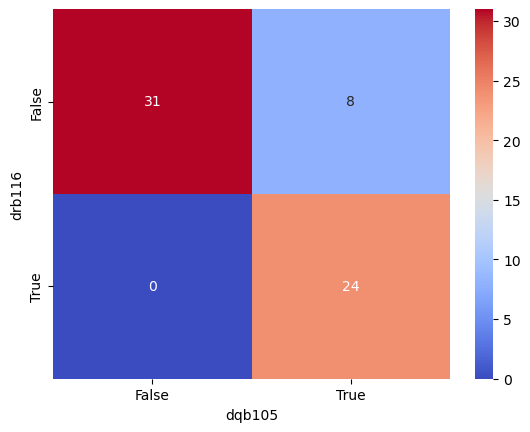

In [14]:
sns.heatmap(pd.crosstab(ill_pattern_cm.drb116, ill_pattern_cm.dqb105), annot=True, fmt='g', cmap='coolwarm')

In [15]:
ill_pattern_cm.a02.value_counts()

True     32
False    31
Name: a02, dtype: int64

In [16]:
32/63

0.5079365079365079

In [17]:
wo_junk = cm[(cm.sum_clones > 1)]

<AxesSubplot:xlabel='dqb105', ylabel='drb116'>

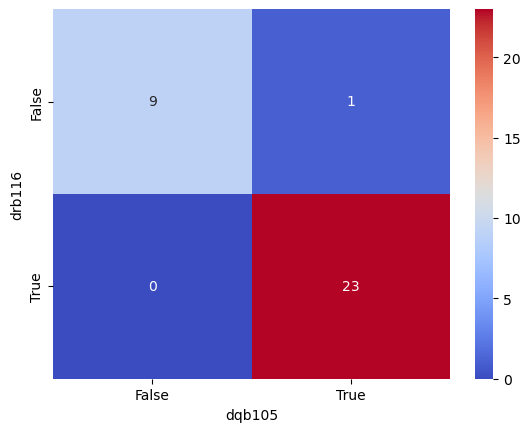

In [18]:
sns.heatmap(pd.crosstab(wo_junk.drb116, wo_junk.dqb105), annot=True, fmt='g', cmap='coolwarm')

In [19]:
wo_junk

,CASSRTGTGSSYNSPLHF,CASSRTGQGSSYNSPLHF,CASSRTGGGSSYNSPLHF,CASSRTGIGSSYNSPLHF,CASSRTGAGSSYNSPLHF,CASSRTGRGSSYNSPLHF,CASSRTGLGSSYNSPLHF,CASSRTGTRSSYNSPLHF,CASSRTGVGSSYNSPLHF,CASSRTGWGSSYNSPLHF,CASSRTGFGSSYNSPLHF,CASSRTGMGSSYNSPLHF,CASSRTGSGSSYNSPLHF,run,COVID_status,folder,sum_clones,a02,drb116,dqb105
38,6,5,5,5,5,5,6,5,5,5,8,5,5,670004990808_S10_L001,COVID,2020/09_FMBA_NovaSeq3_DNA,70,True,True,True
46,4,4,5,4,4,4,4,2,4,4,4,4,4,730002480808_S49_L001,COVID,2020/09_FMBA_NovaSeq3_DNA,51,True,True,True
48,2,2,2,2,2,2,2,0,2,2,2,2,2,670005150808_S177_L002,COVID,2020/09_FMBA_NovaSeq2_DNA,24,False,True,True
71,2,2,2,2,2,3,2,1,2,2,2,2,2,630001450808_S116_L002,COVID,2020/09_FMBA_NovaSeq3_DNA,26,True,True,True
78,2,2,3,2,2,2,2,2,2,2,2,2,2,340002960808_S164_L002,COVID,2020/09_FMBA_NovaSeq_DNA,27,True,True,True
119,4,4,4,4,4,4,5,3,4,4,5,4,4,630001500808_S118_L002,COVID,2020/09_FMBA_NovaSeq3_DNA,53,True,True,True
160,5,4,4,4,4,4,5,4,4,4,4,4,4,630000860808_S123_L002,COVID,2020/09_FMBA_NovaSeq3_DNA,54,True,True,True
178,2,2,2,2,2,2,2,1,2,2,2,2,2,340002510808_S180_L002,COVID,2020/09_FMBA_NovaSeq_DNA,25,True,True,True
179,0,0,0,0,0,0,0,1,0,0,1,0,0,500001490808_S49_L001,COVID,2020/09_FMBA_NovaSeq_DNA,2,True,False,False
227,2,2,2,2,2,3,2,1,2,2,2,3,2,540003680808_S1_L001,COVID,2020/09_FMBA_NovaSeq_DNA,27,False,True,True


In [20]:
wo_junk.a02.value_counts()

True     20
False    13
Name: a02, dtype: int64

In [21]:
20/33

0.6060606060606061

In [22]:
cm[cm.sum_clones > 0].a02.sum()

35

In [23]:
cm[cm.sum_clones > 0].dqb105.sum()

36

In [24]:
cm[cm.sum_clones > 0].drb116.sum()

26

In [25]:
cm

,CASSRTGTGSSYNSPLHF,CASSRTGQGSSYNSPLHF,CASSRTGGGSSYNSPLHF,CASSRTGIGSSYNSPLHF,CASSRTGAGSSYNSPLHF,CASSRTGRGSSYNSPLHF,CASSRTGLGSSYNSPLHF,CASSRTGTRSSYNSPLHF,CASSRTGVGSSYNSPLHF,CASSRTGWGSSYNSPLHF,CASSRTGFGSSYNSPLHF,CASSRTGMGSSYNSPLHF,CASSRTGSGSSYNSPLHF,run,COVID_status,folder,sum_clones,a02,drb116,dqb105
0,0,0,0,0,0,0,0,0,0,0,0,0,0,250002490808_S110_L002,COVID,2020/09_FMBA_NovaSeq2_DNA,0,False,False,False
1,0,0,0,0,0,0,0,0,0,0,0,0,0,330000450808_S22_L001,COVID,2020/09_FMBA_NovaSeq2_DNA,0,False,False,False
2,0,0,0,0,0,0,0,0,0,0,0,0,0,050002290808_S117_L002,COVID,2020/09_FMBA_NovaSeq2_DNA,0,True,False,False
3,0,0,0,0,0,0,0,0,0,0,0,0,0,250003530808_S98_L002,COVID,2020/09_FMBA_NovaSeq2_DNA,0,True,False,False
4,0,0,0,0,0,0,0,0,0,0,0,0,0,500003950808_S31_L001,COVID,2020/09_FMBA_NovaSeq2_DNA,0,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,1,0,0,0,0,0,0,0,0,0,0,0,0,p17_28_DNA_S44_L001,COVID,2021/01_FMBA_NovaSeq9,1,True,False,False
1221,0,0,0,0,0,0,0,0,0,0,0,0,0,p17_62_DNA_S74_L001,COVID,2021/01_FMBA_NovaSeq9,0,False,False,False
1222,0,0,0,0,0,0,0,0,0,0,0,0,0,p17_57_DNA_S69_L001,COVID,2021/01_FMBA_NovaSeq9,0,False,False,False
1223,0,0,0,0,0,0,0,0,0,0,0,0,0,p17_52_DNA_S65_L001,COVID,2021/01_FMBA_NovaSeq9,0,True,False,True


In [26]:
cm.sum_clones

0       0
1       0
2       0
3       0
4       0
       ..
1220    1
1221    0
1222    0
1223    0
1224    0
Name: sum_clones, Length: 1225, dtype: int64

1.8765377686735512e-06 0.0028531072681378528 0.09203097227371097 0.07429802398589193 1.0484812318942447e-06
-9.700329299003088e-06 1.4314437799684054 -0.01201671183430857 0.7267677323836959 2.7751361242202573e-05


Text(0.5, 1.0, 'Log usage of allele specific TCRβ biomarkers')

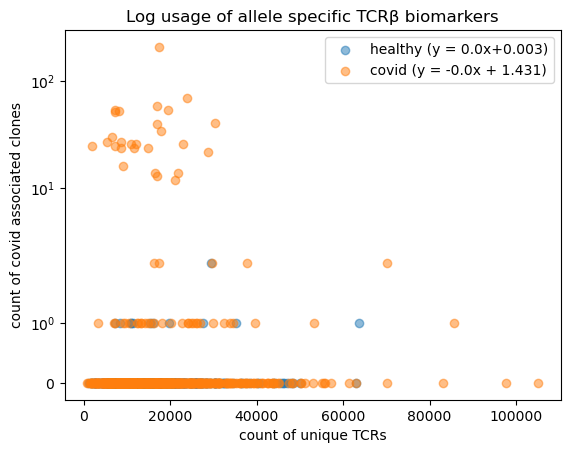

In [27]:
fig, ax = plt.subplots()
significant_clones_distribution(significant_clonotype_matrix=cm[[x for x  in cm.columns if x.startswith('CASS')] + ['run']], 
                                run_to_number_of_clones=prepare_run_column(pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv')), 
                                desc=desc, 
                                data_description='TCRβ biomarkers',
                                by='covid',
                                fit_reg=False,
                                reg_ax=ax)
ax.set_yscale('symlog')
ax.legend()
ax.set_title('Log usage of allele specific TCRβ biomarkers')

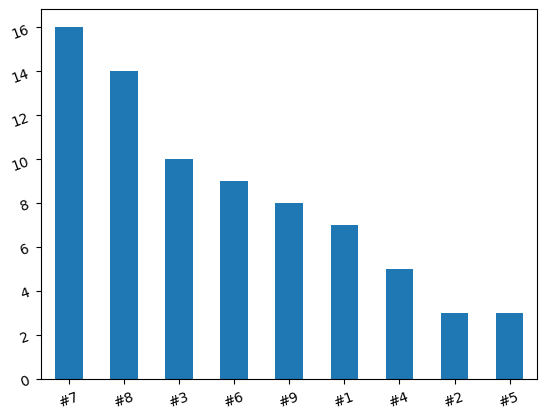

In [28]:
fig, ax = plt.subplots()
cm['short'] = cm.folder.apply(lambda x: ('#' + x.lower().split('novaseq')[1]).replace('#_dna', '#1').replace('_dna', ''))
cm[cm.sum_clones > 0].short.value_counts().plot(kind='bar', ax=ax)
ax.tick_params(labelrotation=20)


In [29]:
cm_with_clones = cm[cm.sum_clones > 0]

In [30]:
cm_with_clones

,CASSRTGTGSSYNSPLHF,CASSRTGQGSSYNSPLHF,CASSRTGGGSSYNSPLHF,CASSRTGIGSSYNSPLHF,CASSRTGAGSSYNSPLHF,CASSRTGRGSSYNSPLHF,CASSRTGLGSSYNSPLHF,CASSRTGTRSSYNSPLHF,CASSRTGVGSSYNSPLHF,CASSRTGWGSSYNSPLHF,...,CASSRTGMGSSYNSPLHF,CASSRTGSGSSYNSPLHF,run,COVID_status,folder,sum_clones,a02,drb116,dqb105,short
38,6,5,5,5,5,5,6,5,5,5,...,5,5,670004990808_S10_L001,COVID,2020/09_FMBA_NovaSeq3_DNA,70,True,True,True,#3
46,4,4,5,4,4,4,4,2,4,4,...,4,4,730002480808_S49_L001,COVID,2020/09_FMBA_NovaSeq3_DNA,51,True,True,True,#3
48,2,2,2,2,2,2,2,0,2,2,...,2,2,670005150808_S177_L002,COVID,2020/09_FMBA_NovaSeq2_DNA,24,False,True,True,#2
71,2,2,2,2,2,3,2,1,2,2,...,2,2,630001450808_S116_L002,COVID,2020/09_FMBA_NovaSeq3_DNA,26,True,True,True,#3
78,2,2,3,2,2,2,2,2,2,2,...,2,2,340002960808_S164_L002,COVID,2020/09_FMBA_NovaSeq_DNA,27,True,True,True,#1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,1,0,0,0,0,0,0,0,0,0,...,0,0,540000070101_S151_L002,COVID,2020/12_FMBA_Novaseq8_DNA,1,False,False,False,#8
1190,2,2,2,2,2,2,3,1,2,2,...,2,2,780005110101_S50_L001,COVID,2020/12_FMBA_Novaseq8_DNA,26,True,True,True,#8
1200,0,0,0,0,0,0,1,0,0,0,...,0,0,p18_73_DNA_S89_L002,COVID,2021/01_FMBA_NovaSeq9,1,False,False,False,#9
1211,0,0,1,0,0,0,0,0,0,0,...,0,0,p17_9_DNA_S25_L001,COVID,2021/01_FMBA_NovaSeq9,1,False,False,False,#9


In [31]:
mat_df = logomaker.alignment_to_matrix(list(cm_clones.columns))

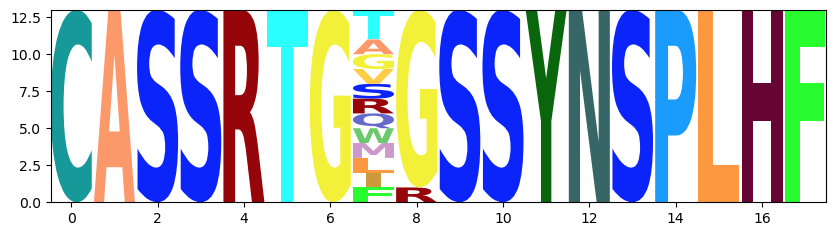

In [32]:
logomaker.Logo(mat_df, color_scheme='skylign_protein', ax=None)

1.8776577744932122e-06 0.0028338058630142035 0.09209981997165476 0.07408070124447147 1.0483160705342904e-06
-9.721579200560232e-06 1.4306177024422513 -0.012052069695360136 0.7259960505822308 2.7730548460859506e-05


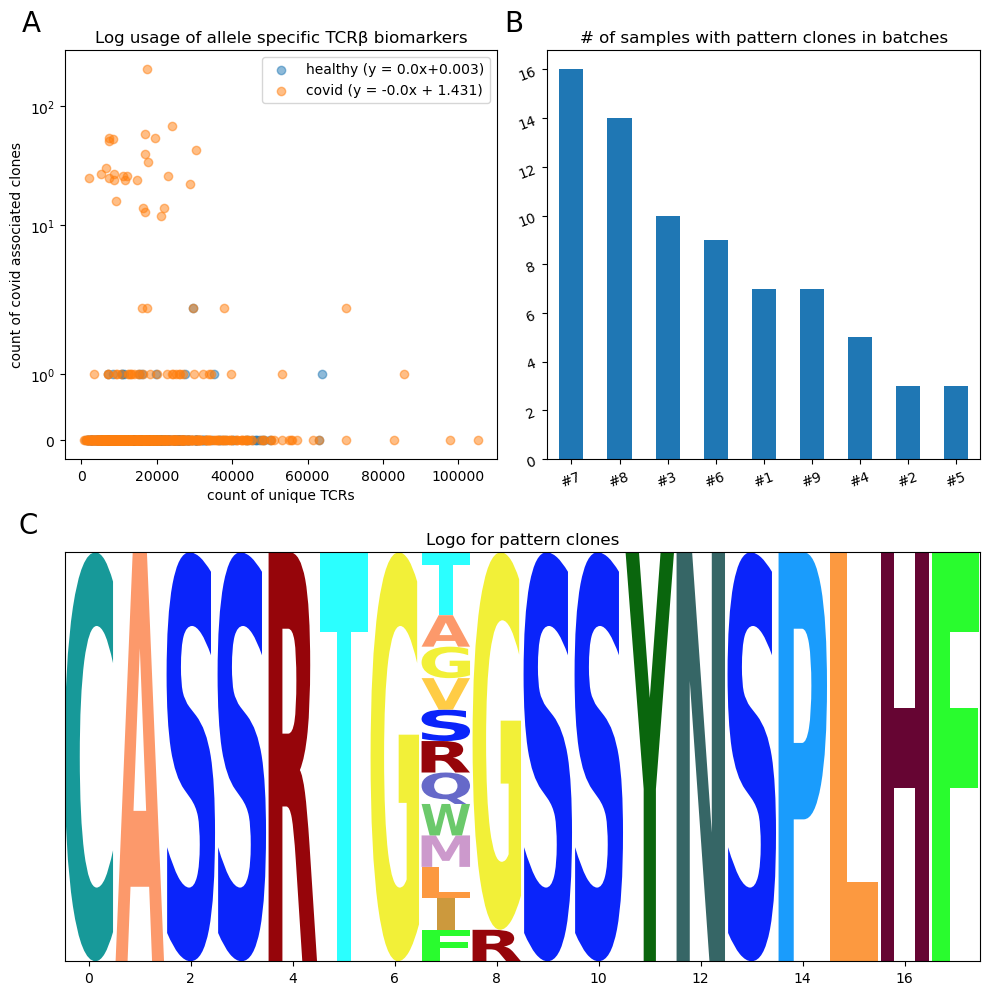

In [47]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(nrows=2, ncols=2)
font_size=20
delta_x=-0.1
delta_y=1.1

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, :])

significant_clones_distribution(significant_clonotype_matrix=cm[[x for x  in cm.columns if x.startswith('CASS')] + ['run']], 
                                run_to_number_of_clones=prepare_run_column(pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv')), 
                                desc=desc, 
                                data_description='TCRβ biomarkers',
                                by='covid',
                                fit_reg=False,
                                reg_ax=ax0)
ax0.set_yscale('symlog')
ax0.legend()
ax0.set_title('Log usage of allele specific TCRβ biomarkers')
ax0.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)


cm[cm.sum_clones > 0].short.value_counts().plot(kind='bar', ax=ax1)
ax1.tick_params(labelrotation=20)
ax1.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
ax1.set_title('# of samples with pattern clones in batches')

####################################################

logomaker.Logo(mat_df, color_scheme='skylign_protein', ax=ax2)
ax2.text(delta_x+0.05, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)
ax2.set_title('Logo for pattern clones')
ax2.yaxis.set_visible(False) 
###################################################
plt.tight_layout()
plt.savefig("figures/fig3.svg")
plt.savefig("figures/fig3.pdf")
plt.savefig("figures/fig3.png")
plt.show()

Figure 3. Analysis of DRB1\*16, DQB1\*05 and COVID-19 associated TCRβ biomarkers.

A. The distribution of the number of pattern biomarkers compared between healthy and COVID-19 cohorts.

B. The number of samples containing pattern biomarkers in each batch of FMBA data.

C. The weblogo describing the pattern of DRB1*16, DQB1*05 and COVID-19 associated TCRβ biomarkers.

# Supplementary Figure 8

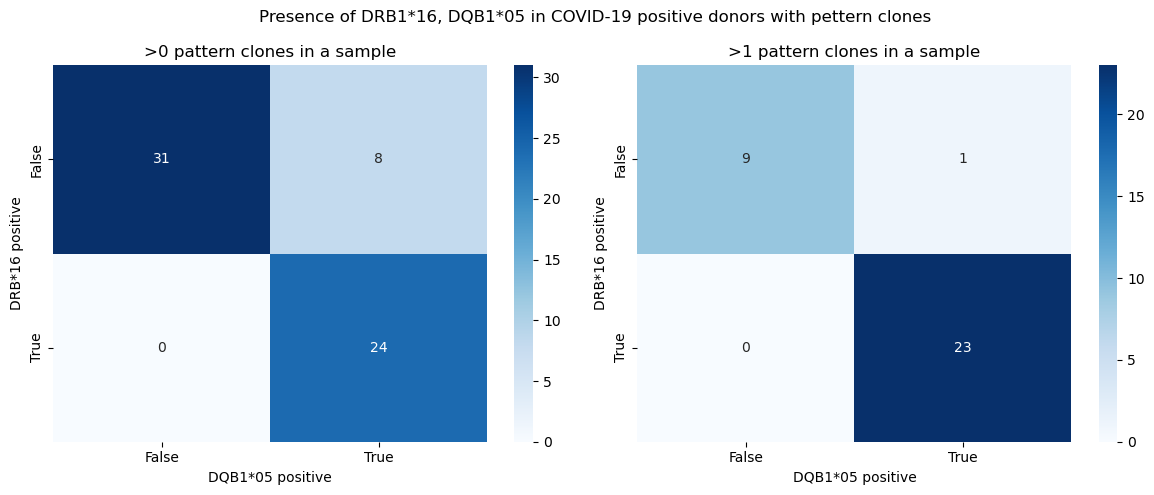

In [47]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

fig = plt.figure(figsize=(12, 5))
gs = GridSpec(nrows=1, ncols=2)
font_size=20
delta_x=-0.1
delta_y=1.1

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

fig.suptitle('Presence of DRB1*16, DQB1*05 in COVID-19 positive donors with pettern clones')

sns.heatmap(pd.crosstab(ill_pattern_cm.drb116, ill_pattern_cm.dqb105), 
            annot=True, 
            fmt='g', 
            cmap=sns.color_palette("Blues", as_cmap=True), ax=ax0)
ax0.set_xlabel('DQB1*05 positive')
ax0.set_ylabel('DRB*16 positive')
ax0.set_title('>0 pattern clones in a sample')

sns.heatmap(pd.crosstab(wo_junk.drb116, wo_junk.dqb105), 
            annot=True, 
            fmt='g', 
            cmap=sns.color_palette("Blues", as_cmap=True), ax=ax1)
ax1.set_xlabel('DQB1*05 positive')
ax1.set_ylabel('DRB*16 positive')
ax1.set_title('>1 pattern clones in a sample')

plt.tight_layout()
plt.savefig("figures/supp_fig8.svg")
plt.savefig("figures/supp_fig8.pdf")
plt.savefig("figures/supp_fig8.png")
plt.show()